# Solving the Maxcut Problem with QAOA

**Download this notebook - {nb-download}`qaoa_maxcut_example.ipynb`**


In this notebook tutorial we will be demonstarting how to solve the maxcut problem using the quantum approximate optimisation algorithm (QAOA). This is a variational algorithm where we run a parameterised circuit to compute an expectation value. We will then try and maximise this expectation value by classically optimsing the circuit parameters.


## The Max-Cut problem

The maxcut problem is a classic problem from graph theory. The problem consists of partitioning the nodes in a graph into two sets $R$ and $B$ such that the number of edges between $R$ and $B$ is maximised. In our statement of the problem, we will colour the nodes red and blue. The objective for maxcut is then to colour the nodes of the graph such that the number of edges connecting red nodes to blue nodes is maximised.


Now consider the graph below with three nodes.


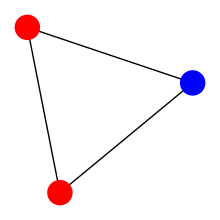

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 0)])
plt.figure(figsize=(2, 2))
nx.draw(G, node_color=["red", "blue", "red"])
plt.show()

There are $2^3$ colourings of the graph. In general there are $2^n$ for an $n$ node graph. The Max-cut problem can then be stated as that of finding the colour assignment which maximises the number of edges between nodes of a different colour.



We can define the following cost function for solving the maxcut problem for a graph $G$

$$
\begin{equation}
C(G)= \frac{1}{2}\sum_{(i,j) \in E(G)} (1-z_i\,z_j)\,, \quad z_i,z_j \in \{0,1\}
\end{equation}
$$

Here $z_i$ and $z_j$ are binary variables representing the colours" of each node and $E(G)$ is the edge set of the graph.




## Quantum Approximate Optimization Algorithm (QAOA)

Introduced in 'A Quantum Approximate Optimization Algorithm' (found at https://arxiv.org/abs/1411.4028). The idea is to prepare a quantum state which encodes a solution to the max-cut problem. Measuring such a state will give us computational basis states (or bitstrings) which correspond to colourings of the graph. 


QAOA is a variational algorithm, which is to say that a paramaterised state is prepared, with the parameters varied to improve the solution. We will have $2p$ parameters where $p$ is our number of layers. In particular, the state prepared has the form 


$$
| \psi  ( \beta, \gamma ) \rangle = U ( \beta_m ) U ( \gamma_m ) ... U (\beta_0) U ( \gamma_0 ) | \psi_0 \rangle
$$

where

$$
U( \beta_i ) = e^{i \beta_i H_B} \quad \& \quad U ( \gamma_i) = e^{i \gamma_i H_P}
$$

For the simple three node graph above the *problem Hamiltonian* is

$$
H_{P(G)} = \frac{3}{2} I - \frac{1}{2} \Big[ ( Z \otimes Z \otimes I ) + ( Z \otimes I \otimes Z ) + ( I \otimes Z \otimes Z ) \Big]
$$

where you will notice that there is a $ Z \otimes Z$ acting between each node which is connected by an edge.
The *mixer Hamiltonian* has the form 

$$
H_B =   ( X \otimes I \otimes I ) + ( I \otimes X \otimes I ) + ( I \otimes I \otimes X )
$$

Here there is an $X$ operator acting on each node. The form of this operator is independent of the graph.


The Pauli Z operator can be used to distinguish between the $|0\rangle$ and $|1\rangle$ basis states as these are eigenstates with eigenvalues $\pm 1$ .

$$
\begin{equation}
H_{P(G)} = \frac{1}{2}\sum_{(i, \,j)} (I-Z_i \,Z_j)
\end{equation}
$$


$$
\begin{equation}
H_B = \sum_i X_i
\end{equation}
$$

Here we use the the convention that $X_i$ means a Pauli X operator will be applied to the "ith" qubit and the identity operator will be applied to all other qubits in the circuit.



## Building the program


In [2]:
from guppylang import guppy
from guppylang.std.quantum import qubit, h, rx
from guppylang.std.qsystem import zz_phase
from guppylang.std.builtins import array, comptime, frozenarray
from guppylang.std.angles import angle
from guppylang.defs import GuppyFunctionDefinition
import networkx as nx

def build_qaoa_instance(graph: nx.Graph, n_layers: int) -> GuppyFunctionDefinition:
    edges = list(graph.edges)
    n_qubits = graph.number_of_nodes()

    @guppy
    def qaoa_instance(
        cost_angles: frozenarray[float, comptime(n_layers)],
        mixer_angles: frozenarray[float, comptime(n_layers)],
    ) -> array[qubit, comptime(n_qubits)]:
        qs = array(qubit() for _ in range(comptime(n_qubits)))
        n = len(qs)
        num_iterations = len(cost_angles)

        for i in range(n):
            h(qs[i])

        for iter_index in range(num_iterations):
            # Add cost layer
            for i, j in comptime(edges):
                zz_phase(qs[i], qs[j], angle(-cost_angles[iter_index] / 2))

            # Add mixer layer
            for i in range(n):
                rx(qs[i], angle(mixer_angles[iter_index]))

        return qs

    return qaoa_instance

## Calculating expectation values


We also need to extract our energy expectation values from a `QsysResult` object after our circuit is processed by the Selene simulator. We do this with the `energy_from_result` function below. Note that the fact that the maxcut cost Hamiltonian $H_P$ contains only commuting terms means that we do not need to calculate our energy expectation using multiple measurement circuits.


In [3]:
from hugr.qsystem.result import QsysResult


def energy_from_result(graph: nx.Graph, result: QsysResult, n_shots: int) -> float:
    energy = 0.0
    dist = result.register_counts()["c"]
    for i, j in graph.edges:
        for meas, count in dist.items():
            prob = count / n_shots
            energy += ((int(meas[i]) ^ int(meas[j])) * prob)

    return energy

In [4]:
import numpy as np
from guppylang.std.quantum import measure_array
from guppylang.std.builtins import result
from numpy.typing import NDArray


def eval_qaoa_energy(
    guess_mixer_angles: NDArray[np.float64],
    guess_cost_angles: NDArray[np.float64],
    graph: nx.Graph,
    p_value: int,
    seed: int,
    shots: int,
) -> tuple[float, QsysResult]:
    # Build Program
    qaoa_instance: GuppyFunctionDefinition = build_qaoa_instance(
        graph=graph, n_layers=p_value,
    )

    @guppy
    def main() -> None:
        qaoa_qubits = qaoa_instance(
            comptime(list(guess_cost_angles)), comptime(list(guess_mixer_angles))
        )
        result("c", measure_array(qaoa_qubits))

    # Execute
    qaoa_result: QsysResult = (
        main.emulator(n_qubits=graph.number_of_nodes())
        .with_shots(shots)
        .with_seed(seed)
        .run()
    )

    return energy_from_result(graph, qaoa_result, shots), qaoa_result

## Setting up the variational loop

In [5]:
## Optimise Energy by Guessing Parameters
def solve_maxcut_instance(
    graph: nx.Graph,
    iterations: int,
    p_value: int,
    n_shots: int,
    seed: int,
) -> tuple[QsysResult, NDArray[np.float64], NDArray[np.float64]]:
    highest_energy = 0
    best_guess_mixer_angles = [0 for _ in range(p_value)]
    best_guess_cost_angles = [0 for _ in range(p_value)]

    rng = np.random.default_rng(seed)

    for _ in range(iterations):
        guess_mixer_angles = rng.uniform(0, 1, p_value)
        guess_cost_angles = rng.uniform(0, 1, p_value)
        qaoa_energy, sys_result = eval_qaoa_energy(
            guess_mixer_angles,
            guess_cost_angles,
            seed=seed,
            shots=n_shots,
            graph=graph,
            p_value=p_value,
        )

        if qaoa_energy > highest_energy:
            print("new highest energy found: ", qaoa_energy)

            best_guess_mixer_angles = np.round(guess_mixer_angles, 3)
            best_guess_cost_angles = np.round(guess_cost_angles, 3)
            highest_energy = qaoa_energy
            best_result: QsysResult = sys_result

    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    best_outputs = tuple([best_result, best_guess_cost_angles, best_guess_mixer_angles])
    return best_outputs

## Solving maxcut for a graph with seven nodes

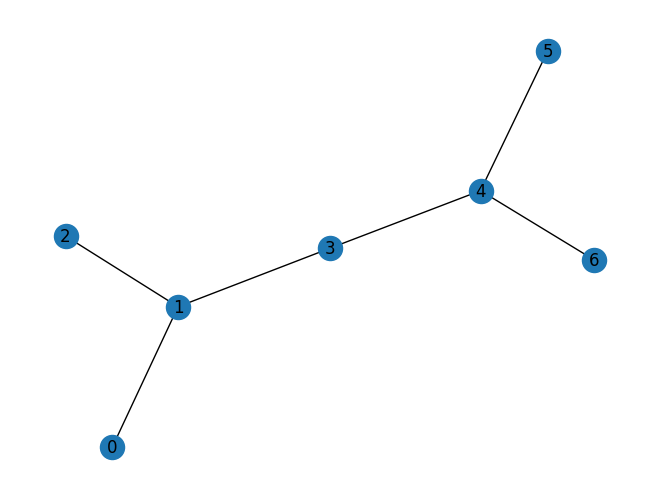

In [6]:
import networkx as nx

max_cut_graph_edges = [(0, 1), (1, 2), (1, 3), (3, 4), (4, 5), (4, 6)]
n_nodes = 7

max_cut_graph = nx.Graph()
max_cut_graph.add_edges_from(max_cut_graph_edges)
nx.draw(max_cut_graph, labels={node: node for node in max_cut_graph.nodes()})

expected_result_strings = ["0100100", "1011011"]

$$
\begin{equation}
H_{P(G)} = \frac{1}{2}\sum_{(i, \, j)} (I -Z_i \,Z_j)
\end{equation}
$$
$$
\begin{equation}
H_{P(G)} = 3 I_{(n=7)} -\frac{1}{2} \big[ Z_0 Z_1 + Z_1 Z_2 +Z_1 Z_3 +Z_3 Z_4 +Z_4 Z_5 +Z_4 Z_6  \big]
\end{equation}
$$

In [7]:
%%time
n_shots = 2000
p_value = 3
random_seed = 12345
iterations = 100

qaoa_result, cost_angles, mixer_angles = solve_maxcut_instance(
    n_shots=n_shots,
    iterations=iterations,
    graph=max_cut_graph,
    seed=random_seed,
    p_value=p_value, # #Cost-mixer layers
)

new highest energy found:  3.1499999999999986
new highest energy found:  3.299999999999997
new highest energy found:  4.306499999999993
new highest energy found:  4.876999999999997
new highest energy found:  4.937499999999999
highest energy:  4.937499999999999
best guess mixer angles:  [0.392 0.247 0.138]
best guess cost angles:  [0.592 0.738 0.608]
CPU times: user 32.1 s, sys: 3.18 s, total: 35.3 s
Wall time: 1min 8s


In [8]:
def validate_qaoa_experiment(
    result: QsysResult, expected_colourings: tuple[list[str]], n_shots: int
) -> None:
    counts_dict = result.register_counts()["c"]
    sorted_shots = counts_dict.most_common()
    most_common_states = [entry[0] for entry in sorted_shots[:2]]

    if most_common_states == expected_colourings:
        num_successful_shots = sum(entry[1] for entry in sorted_shots[:2])
        print(f"Success ratio: {num_successful_shots / n_shots} ")
    else:
        raise ValueError(
            f"The most frequently measured outcomes {most_common_states} did not correspond to the expected graph colouring."
        )

In [9]:
validate_qaoa_experiment(qaoa_result, expected_result_strings, n_shots)

Success ratio: 0.4205 


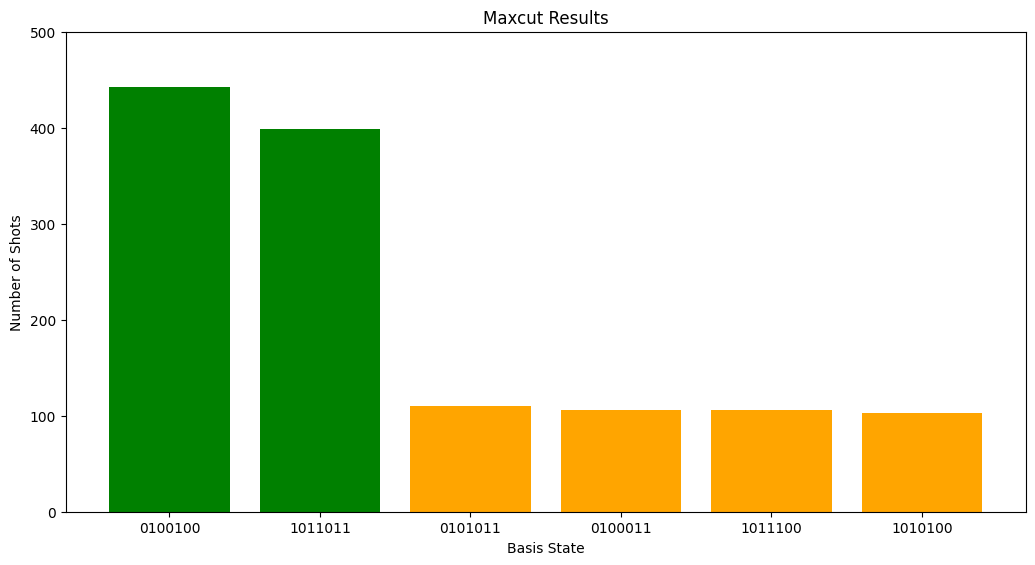

In [10]:
import matplotlib.pyplot as plt


def plot_maxcut_results(result: QsysResult, n_strings: int) -> None:
    """
    Plots Maxcut results in a barchart with the two most common bitstrings highlighted in green.
    """
    counts_dict = result.register_counts()["c"]
    sorted_shots = counts_dict.most_common()
    n_shots = sum(counts_dict.values())

    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1.5, 1])
    color_list = ["green"] * 2 + (["orange"] * (len(x_axis_values) - 2))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Maxcut Results")
    plt.ylim([0, 0.25 * n_shots])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()


plot_maxcut_results(qaoa_result, n_strings=6)

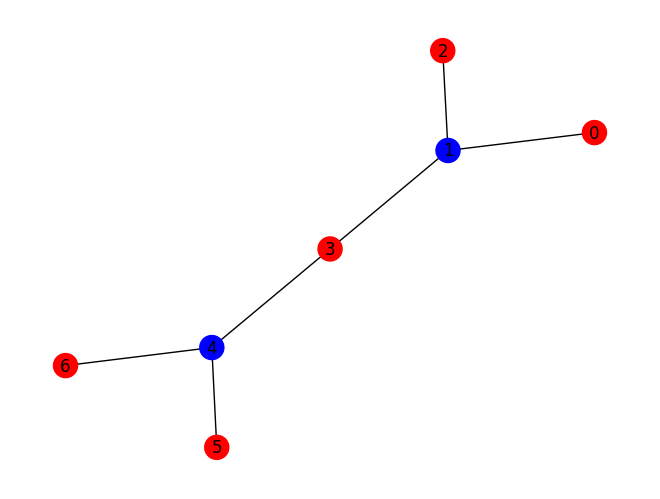

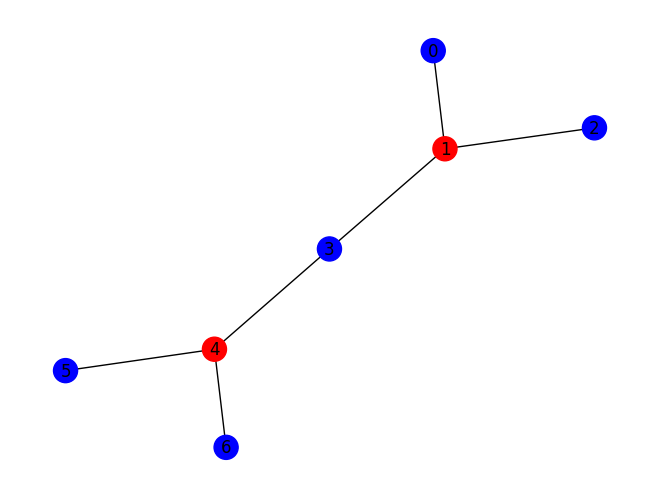

In [11]:
# Here the binary strings in the results correspond to the two optimal colourings of our graph.
G = nx.Graph()
G.add_edges_from(max_cut_graph_edges)

H = nx.Graph()
H.add_edges_from(max_cut_graph_edges)

plt.figure(1)
nx.draw(
    G,
    labels={node: node for node in max_cut_graph.nodes()},
    node_color=["red", "blue", "red", "red", "blue", "red", "red"],
)
plt.figure(2)
nx.draw(
    H,
    labels={node: node for node in max_cut_graph.nodes()},
    node_color=["blue", "red", "blue", "blue", "red", "blue", "blue"],
)

plt.show()